# 1. Importing modules and functions

In [118]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
import glob
xml_files = glob.glob("fingerprints_xml/*.xml")
xml_files.sort()
xml_files

['fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'fingerprints_xml\\EStateFingerprinter.xml',
 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'fingerprints_xml\\Fingerprinter.xml',
 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'fingerprints_xml\\MACCSFingerprinter.xml',
 'fingerprints_xml\\PubchemFingerprinter.xml',
 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'fingerprints_xml\\SubstructureFingerprinter.xml']

In [4]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [5]:
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

# 2.Data entry and curation work set

In [6]:
uploaded_file_ws="datasets/HDAC3_work.sdf"
supplier_ws = Chem.ForwardSDMolSupplier(uploaded_file_ws,sanitize=False)
failed_mols_ws = []
all_mols_ws =[]
wrong_structure_ws=[]
wrong_smiles_ws=[]
y_tr = []
y_bad_index=[]

for i, m in enumerate(supplier_ws):
    structure = Chem.Mol(m)
    all_mols_ws.append(structure)
    y_tr.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ws.append(m)
        wrong_smiles_ws.append(Chem.MolToSmiles(m))
        wrong_structure_ws.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ws), 'molecules')
print('Failed data: ', len(failed_mols_ws), 'molecules')
number_ws =[]
for i in range(len(failed_mols_ws)):
        number_ws.append(str(i+1))
bad_molecules_ws = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ws, 'SMILES of wrong structure: ': wrong_smiles_ws, 'No.': number_ws}, index=None)
bad_molecules_ws = bad_molecules_ws.set_index('No.')
bad_molecules_ws

Original data:  1400 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [7]:
y_tr[:] = [x for i,x in enumerate(y_tr) if i not in y_bad_index]

In [8]:
len(y_tr)

1400

# 3.Standardization SDF file for work set

In [9]:
all_mols_ws[:] = [x for i,x in enumerate(all_mols_ws) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ws)):
    record = Chem.MolToSmiles(all_mols_ws[i])
    records.append(record)

moldf_ws = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ws.append(m)
    
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  1400 molecules


In [10]:
records_ws = []
for i in range(len(moldf_ws)):
    record = Chem.MolToSmiles(moldf_ws[i])
    records_ws.append(record)

In [11]:
df = pd.DataFrame(records_ws, columns=["Smiles"])
df.to_csv('datasets/molecule_ws.smi', sep=',', index=False, header=False)

# 4.Data entry and curation test set

In [12]:
uploaded_file_ts="datasets/HDAC3_test.sdf"
supplier_ts = Chem.ForwardSDMolSupplier(uploaded_file_ts,sanitize=False)
failed_mols_ts = []
all_mols_ts =[]
wrong_structure_ts=[]
wrong_smiles_ts=[]
y_ts = []
y_bad_index=[]
for i, m in enumerate(supplier_ts):
    structure = Chem.Mol(m)
    all_mols_ts.append(structure)
    y_ts.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ts.append(m)
        wrong_smiles_ts.append(Chem.MolToSmiles(m))
        wrong_structure_ts.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ts), 'molecules')
print('Failed data: ', len(failed_mols_ts), 'molecules')
number_ts =[]
for i in range(len(failed_mols_ts)):
        number_ts.append(str(i+1))
bad_molecules_ts = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ts, 'SMILES of wrong structure: ': wrong_smiles_ts, 'No.': number_ts}, index=None)
bad_molecules_ts = bad_molecules_ts.set_index('No.')
bad_molecules_ts

Original data:  351 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [13]:
y_ts[:] = [x for i,x in enumerate(y_ts) if i not in y_bad_index]

In [14]:
len(y_ts)

351

# 5.Standardization SDF file for test set

In [15]:
all_mols_ts[:] = [x for i,x in enumerate(all_mols_ts) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ts)):
    record = Chem.MolToSmiles(all_mols_ts[i])
    records.append(record)

moldf_ts = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ts.append(m)
    
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  351 molecules


In [16]:
records_ts = []
for i in range(len(moldf_ts)):
    record = Chem.MolToSmiles(moldf_ts[i])
    records_ts.append(record)

In [17]:
df_ts = pd.DataFrame(records_ts, columns=["Smiles"])
df_ts.to_csv('datasets/molecule_ts.smi', sep=',', index=False, header=False)

# 6.Descriptor calculation for work set

In [18]:
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

### PubChem FPs

In [19]:
from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file = ''.join([fingerprint,'.csv']) 
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ws.smi', 
                d_file=fingerprint_output_file, 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [20]:
descriptors_PubChem = pd.read_csv('PubChem.csv')

In [21]:
descriptors_PubChem

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,AUTOGEN_molecule_ws_1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_molecule_ws_2,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_molecule_ws_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_molecule_ws_4,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_molecule_ws_5,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,AUTOGEN_molecule_ws_1396,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1396,AUTOGEN_molecule_ws_1397,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1397,AUTOGEN_molecule_ws_1398,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1398,AUTOGEN_molecule_ws_1399,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
descriptors_ws = descriptors_PubChem.drop('Name', axis=1)

In [23]:
x_tr = np.array(descriptors_ws, dtype=np.float32)
y_tr = np.array(y_tr, dtype=np.float32)

In [24]:
savetxt('Models/Padels/x_tr_PubChem.csv', x_tr, delimiter=',')

In [25]:
x_tr.shape

(1400, 881)

# 7.Descriptor calculation for test set

In [26]:
from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file = ''.join([fingerprint,'_ts.csv']) #PubChem.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ts.smi', 
                d_file=fingerprint_output_file, #'PubChem.csv'
                #descriptortypes='PubChem.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=False,
                fingerprints=True)

In [27]:
descriptors_PubChem_ts = pd.read_csv('PubChem_ts.csv')

In [104]:
x_ts = descriptors_PubChem_ts.drop('Name', axis=1)

In [105]:
desc_ts=x_ts

In [29]:
x_ts.shape

(351, 881)

 # BASELINE GradientBoostingRegressor

In [30]:
seed = 42

In [31]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [32]:
param_grid = {'learning_rate': [0.01, 0.04],
                  'subsample'    : [0.9, 0.5],
                  'n_estimators' : [100,1000, 2000],
                  'max_depth'    : [4, 10]
                 }

In [33]:
m = GridSearchCV(GradientBoostingRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [37]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.04], 'max_depth': [4, 10],
                         'n_estimators': [100, 1000, 2000],
                         'subsample': [0.9, 0.5]},
             verbose=1)

In [38]:
best_GBR = m.best_estimator_

In [39]:
m.best_params_

{'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 1000,
 'subsample': 0.5}

In [74]:
y_pred_CV_GBR = cross_val_predict(best_GBR, x_tr, y_tr, cv=cv)

In [75]:
y_pred_CV_GBR

array([4.66001691, 4.93949643, 5.45580664, ..., 9.60259037, 7.21988858,
       9.19001709])

In [78]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.64

In [79]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.73

# 9. Prediction for test set's molecules

In [80]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)
len(y_ts)

351

In [81]:
y_pred_GBR = best_GBR.predict(x_ts)

In [82]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.66

In [83]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.72

# save the model to disk

In [57]:
pickle.dump(best_GBR, open('Models/Padels/HDAC6_GBR_PubChem.pkl', 'wb'))

# load the model from disk

In [73]:
best_GBR = pickle.load(open('Models/Padels/HDAC6_GBR_PubChem.pkl', 'rb'))

In [58]:
estimator = GradientBoostingRegressor(learning_rate=0.01,subsample= 0.5, n_estimators=1000, max_depth= 10,  random_state=seed)

# VarianceThreshold

In [59]:
from sklearn.feature_selection import VarianceThreshold

In [60]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [63]:
x_tr_const_and_nearcont=variance_threshold_selector(descriptors_ws, 0.05)
x_tr_const_and_nearcont

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP12,PubchemFP13,PubchemFP16,PubchemFP19,PubchemFP20,PubchemFP23,PubchemFP24,...,PubchemFP779,PubchemFP797,PubchemFP798,PubchemFP800,PubchemFP803,PubchemFP818,PubchemFP819,PubchemFP821,PubchemFP824,PubchemFP833
0,1,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1396,0,0,0,1,1,1,1,0,0,0,...,1,1,0,0,0,0,1,1,0,0
1397,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1398,1,1,1,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
estimator.fit(x_tr_const_and_nearcont, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [84]:
y_pred_CV_GBR = cross_val_predict(estimator, x_tr_const_and_nearcont, y_tr, cv=cv, n_jobs=-1)

In [85]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.64

In [86]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.73

# Removing highly correlated features

In [91]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP12,PubchemFP13,PubchemFP16,PubchemFP19,PubchemFP20,PubchemFP23,PubchemFP24,...,PubchemFP779,PubchemFP797,PubchemFP798,PubchemFP800,PubchemFP803,PubchemFP818,PubchemFP819,PubchemFP821,PubchemFP824,PubchemFP833
PubchemFP0,1.000000,0.974432,0.745128,0.199785,0.477958,0.147781,0.064406,0.271942,0.127935,0.126702,...,0.069585,0.157275,0.172077,0.008834,0.147790,0.123082,0.129788,0.234136,0.110133,0.107868
PubchemFP1,0.974432,1.000000,0.764679,0.144962,0.464066,0.122131,0.055025,0.253294,0.104984,0.095620,...,0.058205,0.145292,0.162152,0.000571,0.140197,0.113030,0.121771,0.217848,0.102972,0.117640
PubchemFP2,0.745128,0.764679,1.000000,0.247008,0.336876,0.070357,0.046191,0.123495,0.066441,0.128883,...,0.006899,0.106240,0.089085,0.049472,0.078893,0.052763,0.071212,0.073004,0.056907,0.191850
PubchemFP12,0.199785,0.144962,0.247008,1.000000,0.130179,0.049513,0.082497,0.184806,0.115083,0.174306,...,0.132125,0.093726,0.095792,0.117778,0.086805,0.091856,0.086507,0.209710,0.072981,0.180405
PubchemFP13,0.477958,0.464066,0.336876,0.130179,1.000000,0.067710,0.076251,0.264748,0.087266,0.044914,...,0.123486,0.211643,0.253734,0.054847,0.210568,0.211015,0.052206,0.236580,0.222293,0.018461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PubchemFP818,0.123082,0.113030,0.052763,0.091856,0.211015,0.082472,0.037285,0.093194,0.023564,0.010830,...,0.159962,0.388332,0.157228,0.222575,0.325099,1.000000,0.128831,0.023073,0.220122,0.038716
PubchemFP819,0.129788,0.121771,0.071212,0.086507,0.052206,0.138830,0.077509,0.212170,0.002503,0.001824,...,0.043015,0.259059,0.170482,0.020915,0.300642,0.128831,1.000000,0.093819,0.161281,0.024849
PubchemFP821,0.234136,0.217848,0.073004,0.209710,0.236580,0.061694,0.056009,0.120953,0.111100,0.152377,...,0.166272,0.195668,0.210763,0.071065,0.048687,0.023073,0.093819,1.000000,0.099181,0.011138
PubchemFP824,0.110133,0.102972,0.056907,0.072981,0.222293,0.221165,0.070332,0.365781,0.120006,0.084714,...,0.146768,0.145455,0.740720,0.102045,0.676240,0.220122,0.161281,0.099181,1.000000,0.022080


In [92]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP12,PubchemFP13,PubchemFP16,PubchemFP19,PubchemFP20,PubchemFP23,PubchemFP24,...,PubchemFP779,PubchemFP797,PubchemFP798,PubchemFP800,PubchemFP803,PubchemFP818,PubchemFP819,PubchemFP821,PubchemFP824,PubchemFP833
PubchemFP0,1.000000,0.974432,0.745128,0.199785,0.477958,0.147781,0.064406,0.271942,0.127935,0.126702,...,0.069585,0.157275,0.172077,0.008834,0.147790,0.123082,0.129788,0.234136,0.110133,0.107868
PubchemFP1,0.974432,1.000000,0.764679,0.144962,0.464066,0.122131,0.055025,0.253294,0.104984,0.095620,...,0.058205,0.145292,0.162152,0.000571,0.140197,0.113030,0.121771,0.217848,0.102972,0.117640
PubchemFP2,0.745128,0.764679,1.000000,0.247008,0.336876,0.070357,0.046191,0.123495,0.066441,0.128883,...,0.006899,0.106240,0.089085,0.049472,0.078893,0.052763,0.071212,0.073004,0.056907,0.191850
PubchemFP12,0.199785,0.144962,0.247008,1.000000,0.130179,0.049513,0.082497,0.184806,0.115083,0.174306,...,0.132125,0.093726,0.095792,0.117778,0.086805,0.091856,0.086507,0.209710,0.072981,0.180405
PubchemFP13,0.477958,0.464066,0.336876,0.130179,1.000000,0.067710,0.076251,0.264748,0.087266,0.044914,...,0.123486,0.211643,0.253734,0.054847,0.210568,0.211015,0.052206,0.236580,0.222293,0.018461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PubchemFP818,0.123082,0.113030,0.052763,0.091856,0.211015,0.082472,0.037285,0.093194,0.023564,0.010830,...,0.159962,0.388332,0.157228,0.222575,0.325099,1.000000,0.128831,0.023073,0.220122,0.038716
PubchemFP819,0.129788,0.121771,0.071212,0.086507,0.052206,0.138830,0.077509,0.212170,0.002503,0.001824,...,0.043015,0.259059,0.170482,0.020915,0.300642,0.128831,1.000000,0.093819,0.161281,0.024849
PubchemFP821,0.234136,0.217848,0.073004,0.209710,0.236580,0.061694,0.056009,0.120953,0.111100,0.152377,...,0.166272,0.195668,0.210763,0.071065,0.048687,0.023073,0.093819,1.000000,0.099181,0.011138
PubchemFP824,0.110133,0.102972,0.056907,0.072981,0.222293,0.221165,0.070332,0.365781,0.120006,0.084714,...,0.146768,0.145455,0.740720,0.102045,0.676240,0.220122,0.161281,0.099181,1.000000,0.022080


In [93]:
mask=np.triu(np.ones_like(cor_df, dtype=bool))

In [94]:
tri_df=cor_df.mask(mask)
tri_df

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP12,PubchemFP13,PubchemFP16,PubchemFP19,PubchemFP20,PubchemFP23,PubchemFP24,...,PubchemFP779,PubchemFP797,PubchemFP798,PubchemFP800,PubchemFP803,PubchemFP818,PubchemFP819,PubchemFP821,PubchemFP824,PubchemFP833
PubchemFP0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PubchemFP1,0.974432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PubchemFP2,0.745128,0.764679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PubchemFP12,0.199785,0.144962,0.247008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PubchemFP13,0.477958,0.464066,0.336876,0.130179,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PubchemFP818,0.123082,0.113030,0.052763,0.091856,0.211015,0.082472,0.037285,0.093194,0.023564,0.010830,...,0.159962,0.388332,0.157228,0.222575,0.325099,NaN,NaN,NaN,NaN,NaN
PubchemFP819,0.129788,0.121771,0.071212,0.086507,0.052206,0.138830,0.077509,0.212170,0.002503,0.001824,...,0.043015,0.259059,0.170482,0.020915,0.300642,0.128831,NaN,NaN,NaN,NaN
PubchemFP821,0.234136,0.217848,0.073004,0.209710,0.236580,0.061694,0.056009,0.120953,0.111100,0.152377,...,0.166272,0.195668,0.210763,0.071065,0.048687,0.023073,0.093819,NaN,NaN,NaN
PubchemFP824,0.110133,0.102972,0.056907,0.072981,0.222293,0.221165,0.070332,0.365781,0.120006,0.084714,...,0.146768,0.145455,0.740720,0.102045,0.676240,0.220122,0.161281,0.099181,NaN,NaN


In [95]:
to_drop=[c for c in tri_df.columns if any(tri_df[c]>0.95) ]
to_drop

['PubchemFP0',
 'PubchemFP23',
 'PubchemFP33',
 'PubchemFP37',
 'PubchemFP115',
 'PubchemFP143',
 'PubchemFP150',
 'PubchemFP180',
 'PubchemFP187',
 'PubchemFP293',
 'PubchemFP294',
 'PubchemFP300',
 'PubchemFP301',
 'PubchemFP334',
 'PubchemFP342',
 'PubchemFP356',
 'PubchemFP358',
 'PubchemFP362',
 'PubchemFP371',
 'PubchemFP372',
 'PubchemFP373',
 'PubchemFP375',
 'PubchemFP376',
 'PubchemFP379',
 'PubchemFP380',
 'PubchemFP381',
 'PubchemFP382',
 'PubchemFP387',
 'PubchemFP389',
 'PubchemFP394',
 'PubchemFP395',
 'PubchemFP396',
 'PubchemFP399',
 'PubchemFP400',
 'PubchemFP403',
 'PubchemFP406',
 'PubchemFP412',
 'PubchemFP418',
 'PubchemFP421',
 'PubchemFP422',
 'PubchemFP435',
 'PubchemFP442',
 'PubchemFP447',
 'PubchemFP450',
 'PubchemFP467',
 'PubchemFP470',
 'PubchemFP472',
 'PubchemFP473',
 'PubchemFP474',
 'PubchemFP476',
 'PubchemFP480',
 'PubchemFP482',
 'PubchemFP484',
 'PubchemFP485',
 'PubchemFP487',
 'PubchemFP498',
 'PubchemFP501',
 'PubchemFP502',
 'PubchemFP503',
 '

In [96]:
reduced_df_cor=x_tr_const_and_nearcont.drop(to_drop, axis=1)

In [223]:
reduced_df_cor

,PubchemFP1,PubchemFP2,PubchemFP12,PubchemFP13,PubchemFP16,PubchemFP19,PubchemFP20,PubchemFP24,PubchemFP34,PubchemFP116,...,PubchemFP779,PubchemFP797,PubchemFP798,PubchemFP800,PubchemFP803,PubchemFP818,PubchemFP819,PubchemFP821,PubchemFP824,PubchemFP833
0,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1396,0,0,1,1,1,1,0,0,0,1,...,1,1,0,0,0,0,1,1,0,0
1397,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1398,1,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
estimator.fit(reduced_df_cor, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [99]:
y_pred_CV_GBR = cross_val_predict(estimator, reduced_df_cor, y_tr, cv=cv, n_jobs=-1)

In [100]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.64

In [101]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.73

In [102]:
feature_name_reduced_df_cor = reduced_df_cor.columns.tolist()
len(feature_name_reduced_df_cor)

199

# Prediction for test set's molecules

In [106]:
x_ts=desc_ts[feature_name_reduced_df_cor]

In [107]:
y_ts = np.array(y_ts, dtype=np.float32)

In [108]:
y_pred_GBR = estimator.predict(x_ts)

In [109]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.68

In [110]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.7

# save the model to disk

In [114]:
pickle.dump(estimator, open('Models/Padels/GBR_after_cross_corr_PubChem.pkl', 'wb'))

# load the model from disk

In [73]:
GBR_after_cross_corr_PubChem = pickle.load(open('Models/Padels/GBR_after_cross_corr_PubChem.pkl', 'rb'))

 # Recursive feature elimination

In [115]:
from sklearn.feature_selection import RFECV
estimator

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [116]:
rfecv = RFECV(estimator=estimator, cv=cv, scoring='r2')
rfecv.fit(reduced_df_cor, y_tr)

RFECV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
      estimator=GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                          n_estimators=1000, random_state=42,
                                          subsample=0.5),
      scoring='r2')

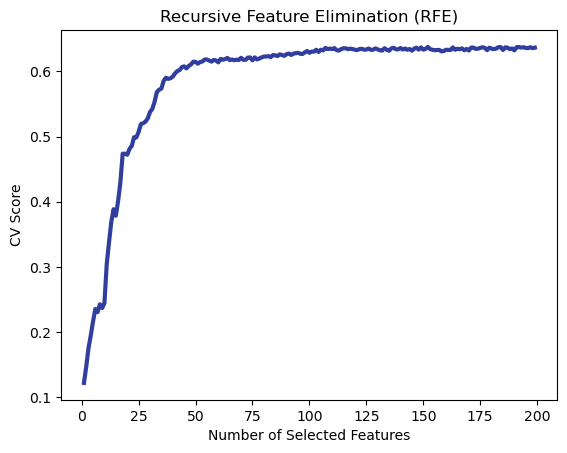

The optimal number of features: 152


In [119]:
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()
print("The optimal number of features: {}".format(rfecv.n_features_))

Make a new DataFrame called "X_rfe" that contains selected features.

In [120]:
reduced_df_cor = np.array(reduced_df_cor, dtype=np.float32)

In [121]:
X_rfe = reduced_df_cor[:, rfecv.support_]

In [122]:
X_rfe.shape

(1400, 152)

In [123]:
estimator.fit(X_rfe, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [124]:
y_pred_CV_GBR = cross_val_predict(estimator, X_rfe, y_tr, cv=cv, n_jobs=-1)

In [125]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.64

In [126]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.73

In [128]:
reduced_df_cor=x_tr_const_and_nearcont.drop(to_drop, axis=1)

In [129]:
feature_idx = rfecv.get_support()
feature_name_rfecv = reduced_df_cor.columns[feature_idx]
feature_name_rfecv

Index(['PubchemFP1', 'PubchemFP2', 'PubchemFP12', 'PubchemFP13', 'PubchemFP16',
       'PubchemFP19', 'PubchemFP20', 'PubchemFP24', 'PubchemFP34',
       'PubchemFP116',
       ...
       'PubchemFP776', 'PubchemFP777', 'PubchemFP779', 'PubchemFP797',
       'PubchemFP798', 'PubchemFP800', 'PubchemFP818', 'PubchemFP819',
       'PubchemFP821', 'PubchemFP833'],
      dtype='object', length=152)

In [350]:
from pathlib import Path

In [351]:
urls=list(feature_name_rfecv)

In [356]:
path = Path('feature_name_rfecv_PubchemFP.txt')

In [357]:
path.write_text('\n'.join(urls))

1964

# Prediction for test set's molecules

In [150]:
x_ts=desc_ts[feature_name_rfecv]

In [880]:
y_ts = np.array(y_ts, dtype=np.float32)

In [881]:
y_pred_GBR = estimator.predict(x_ts)

In [882]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.71

In [883]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.66

# save the model to disk

In [273]:
pickle.dump(estimator, open('Models/Padels/HDAC3_GBR_Pubchem_final_FS.pkl', 'wb'))

# load the model from disk

In [134]:
best_GBR = pickle.load(open('Models/Morgan_FP/HDAC3_GBR_Pubchem_final_FS.pkl', 'rb'))

# Y-randomization GradientBoostingRegressor model

In [138]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_GBR, X_rfe, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  5.1min


True score =  0.64 
Y-randomization =  -0.39 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.9min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [140]:
neighbors_k= pairwise_distances(X_rfe, n_jobs=-1)
neighbors_k.sort(0)

In [141]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,1.732051,0.000000,2.449490,2.449490,1.000000,3.000000,3.316625,3.162278,...,2.236068,1.000000,2.000000,2.000000,2.000000,0.000000,1.000000,0.000000,4.690416,2.828427
2,0.000000,0.000000,2.449490,2.828427,3.162278,3.464102,3.316625,3.605551,3.464102,3.316625,...,4.123106,2.236068,2.236068,2.449490,2.449490,0.000000,2.449490,0.000000,4.898980,2.828427
3,0.000000,1.000000,2.449490,2.828427,4.242640,3.872983,3.741657,4.000000,3.872983,3.605551,...,4.123106,2.449490,2.236068,2.449490,2.645751,1.000000,2.828427,1.000000,5.000000,3.162278
4,1.000000,2.236068,2.645751,2.828427,4.242640,4.000000,4.000000,4.123106,3.872983,3.605551,...,4.123106,4.123106,2.236068,2.645751,2.645751,1.414214,2.828427,1.414214,5.000000,3.316625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,8.602325,8.485281,8.000000,8.306623,8.831760,8.944272,8.888194,8.831760,8.944272,8.366600,...,8.246211,8.660254,8.944272,8.831760,8.831760,8.944272,9.165152,8.944272,9.055386,9.380832
1396,8.602325,8.485281,8.000000,8.306623,8.888194,8.944272,8.888194,8.888194,8.944272,8.366600,...,8.306623,8.660254,8.944272,8.944272,8.831760,9.000000,9.219544,9.000000,9.110434,9.380832
1397,8.602325,8.544003,8.000000,8.366600,8.888194,9.000000,8.888194,8.944272,9.000000,8.366600,...,8.366600,8.717798,8.944272,8.944272,8.888194,9.000000,9.219544,9.000000,9.165152,9.539392
1398,8.660254,8.544003,8.124039,8.426149,8.944272,9.000000,8.944272,8.944272,9.000000,8.426149,...,8.485281,8.717798,9.110434,9.000000,8.888194,9.000000,9.219544,9.000000,9.165152,9.591663


In [142]:
similarity= neighbors_k

In [143]:
Dmean=np.mean(similarity[1,:])

In [144]:
round(Dmean, 2)

1.89

In [145]:
std=np.std(similarity[1,:])

In [146]:
round(std, 2)

1.27

In [147]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.53


In [152]:
x_ts=desc_ts[feature_name_rfecv]

In [154]:
neighbors_k_ts= pairwise_distances(X_rfe,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [155]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0.000000,3.162278,5.567764,2.000000,1.732051,3.605551,1.000000,1.732051,2.828427,3.162278,...,0.000000,2.645751,2.000000,1.732051,1.732051,2.000000,1.414214,2.000000,3.464102,2.236068
1,0.000000,4.898979,5.656854,3.316625,2.449490,4.000000,3.316625,1.732051,2.828427,3.162278,...,1.000000,3.000000,2.236068,2.000000,3.316625,2.236068,2.000000,2.236068,3.605551,2.645751
2,0.000000,5.744563,5.656854,3.464102,2.828427,4.123106,3.464102,2.000000,4.000000,3.316625,...,2.236068,3.000000,2.645751,3.000000,3.316625,2.236068,2.449490,2.449490,3.605551,2.645751
3,0.000000,5.744563,5.656854,3.605551,3.464102,4.123106,3.741657,2.828427,4.242641,3.872983,...,2.449490,3.000000,2.828427,3.000000,3.316625,2.236068,2.645751,2.449490,3.605551,2.828427
4,1.000000,5.830952,5.830952,3.872983,5.099020,4.242641,4.000000,3.316625,4.472136,4.242641,...,3.464102,3.162278,4.358899,3.162278,3.741657,2.449490,2.645751,2.645751,3.605551,2.828427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,8.602325,8.426150,8.717798,9.165151,9.110434,9.219544,9.000000,9.433981,8.185353,9.433981,...,8.544004,8.485281,8.774964,9.327379,9.219544,8.888194,9.165151,9.000000,9.055385,8.888194
1396,8.602325,8.426150,8.717798,9.219544,9.219544,9.219544,9.000000,9.486833,8.246211,9.486833,...,8.544004,8.544004,8.774964,9.380832,9.219544,8.888194,9.165151,9.055385,9.110434,8.944272
1397,8.602325,8.485281,8.774964,9.380832,9.273618,9.273618,9.055385,9.486833,8.246211,9.486833,...,8.544004,8.544004,8.831761,9.380832,9.380832,8.888194,9.273618,9.110434,9.327379,8.944272
1398,8.660254,8.485281,8.831761,9.433981,9.327379,9.327379,9.055385,9.591663,8.246211,9.591663,...,8.602325,8.602325,8.888194,9.380832,9.433981,8.888194,9.327379,9.273618,9.433981,9.000000


In [156]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[0.    3.162 5.568 2.    1.732 3.606 1.    1.732 2.828 3.162 3.    2.
 4.123 2.236 2.236 1.732 1.    2.449 4.472 2.828 1.414 2.449 4.243 0.
 0.    1.414 1.    1.    2.646 3.162 1.414 2.    2.449 2.646 2.828 2.
 4.    2.    3.317 3.162 5.    4.123 2.828 4.359 3.162 3.    4.583 3.464
 0.    0.    1.    3.742 2.646 1.    1.414 4.359 2.    1.    0.    1.
 1.    2.    3.317 4.123 4.243 0.    3.464 2.    0.    3.317 3.317 1.414
 2.646 1.414 1.    0.    1.    1.    0.    2.236 1.    3.162 2.236 2.
 4.    0.    2.449 1.    0.    5.385 0.    5.099 2.449 2.646 0.    2.449
 1.    1.732 0.    1.414 3.742 1.    3.873 1.    1.732 0.    3.    1.
 1.    1.414 1.    1.    1.414 1.    4.123 1.414 1.    0.    1.732 3.162
 3.    2.    1.414 2.646 1.732 2.236 2.236 3.606 1.732 2.    1.    4.
 0.    1.732 1.414 0.    0.    1.    3.606 1.    4.472 1.414 1.414 1.732
 0.    3.    1.414 1.    3.    3.742 1.    3.    1.414 1.414 0.    2.449
 1.732 1.414 2.828 1.732 2.    2.    1.    2.    0.    2.449 4.    0.
 3

In [157]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True False False  True  True False  True  True False False False  True
 False  True  True  True  True  True False False  True  True False  True
  True  True  True  True False False  True  True  True False False  True
 False  True False False False False False False False False False False
  True  True  True False False  True  True False  True  True  True  True
  True  True False False False  True False  True  True False False  True
 False  True  True  True  True  True  True  True  True False  True  True
 False  True  True  True  True False  True False  True False  True  True
  True  True  True  True False  True False  True  True  True False  True
  True  True  True  True  True  True False  True  True  True  True False
 False  True  True False  True  True  True False  True  True  True False
  True  True  True  True  True  True False  True False  True  True  True
  True False  True  True False False  True False  True  True  True  True
  True  True False  True  True  True  True  True  T

In [158]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.72


In [159]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   3   4   6   7  11  13  14  15  16  17  20  21  23  24  25  26  27
  30  31  32  35  37  48  49  50  53  54  56  57  58  59  60  61  65  67
  68  71  73  74  75  76  77  78  79  80  82  83  85  86  87  88  90  92
  94  95  96  97  98  99 101 103 104 105 107 108 109 110 111 112 113 115
 116 117 118 121 122 124 125 126 128 129 130 132 133 134 135 136 137 139
 141 142 143 144 146 147 150 152 153 154 155 156 157 159 160 161 162 163
 164 165 167 169 170 171 172 173 176 177 178 179 180 183 184 186 187 188
 189 190 191 192 193 194 196 197 198 199 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 220 221 222 223 226 227 228 230
 231 232 233 234 235 237 238 239 240 242 244 245 246 247 249 250 251 252
 253 254 255 256 257 258 259 261 263 264 266 267 268 269 270 271 272 274
 275 277 280 281 282 283 284 286 287 289 291 294 296 297 298 299 300 301
 303 304 306 308 311 312 315 316 317 319 320 321 322 323 324 325 327 328
 329 330 33

In [160]:
out_Ad=list(np.where(cpd_AD == 0)[0])

#  Prediction only for molecules included in  AD

In [161]:
y_pred_GBR_ad=list(y_pred_GBR)

In [162]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [163]:
len(y_pred_GBR_ad)

254

In [164]:
y_ts_ad=list(y_ts)

In [165]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [166]:
len(y_ts_ad)

254

In [228]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.73

In [227]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.62

# SVM model building and validation

In [229]:
from sklearn.svm import SVR

In [230]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [231]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [232]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [233]:
svm.fit(X_rfe, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [234]:
svm.best_params_
best_svm = svm.best_estimator_

In [235]:
svm.best_params_

{'C': 10, 'gamma': 0.1}

In [331]:
y_pred_CV_svm = cross_val_predict(best_svm, X_rfe, y_tr, cv=cv)

In [332]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.61

In [333]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.76

#  Prediction for test set's molecules

In [239]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [240]:
y_pred_svm = best_svm.predict(x_ts)

In [241]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.65

In [242]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.73

save the model to disk

In [274]:
pickle.dump(best_svm, open('Models/Padels/HDAC3_SVM_PubChem.pkl', 'wb'))

load the model from disk

In [275]:
best_svm = pickle.load(open('Models/Padels/HDAC3_SVM_PubChem.pkl', 'rb'))

# 10. Y-randomization SVM model

In [276]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_svm, X_rfe, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(3),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.9s


True score =  0.608 
Y-randomization =  -0.33 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.6s finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [304]:
neighbors_k= pairwise_distances(X_rfe, n_jobs=-1)
neighbors_k.sort(0)

In [305]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,1.732051,0.000000,2.449490,2.449490,1.000000,3.000000,3.316625,3.162278,...,2.236068,1.000000,2.000000,2.000000,2.000000,0.000000,1.000000,0.000000,4.690416,2.828427
2,0.000000,0.000000,2.449490,2.828427,3.162278,3.464102,3.316625,3.605551,3.464102,3.316625,...,4.123106,2.236068,2.236068,2.449490,2.449490,0.000000,2.449490,0.000000,4.898980,2.828427
3,0.000000,1.000000,2.449490,2.828427,4.242640,3.872983,3.741657,4.000000,3.872983,3.605551,...,4.123106,2.449490,2.236068,2.449490,2.645751,1.000000,2.828427,1.000000,5.000000,3.162278
4,1.000000,2.236068,2.645751,2.828427,4.242640,4.000000,4.000000,4.123106,3.872983,3.605551,...,4.123106,4.123106,2.236068,2.645751,2.645751,1.414214,2.828427,1.414214,5.000000,3.316625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,8.602325,8.485281,8.000000,8.306623,8.831760,8.944272,8.888194,8.831760,8.944272,8.366600,...,8.246211,8.660254,8.944272,8.831760,8.831760,8.944272,9.165152,8.944272,9.055386,9.380832
1396,8.602325,8.485281,8.000000,8.306623,8.888194,8.944272,8.888194,8.888194,8.944272,8.366600,...,8.306623,8.660254,8.944272,8.944272,8.831760,9.000000,9.219544,9.000000,9.110434,9.380832
1397,8.602325,8.544003,8.000000,8.366600,8.888194,9.000000,8.888194,8.944272,9.000000,8.366600,...,8.366600,8.717798,8.944272,8.944272,8.888194,9.000000,9.219544,9.000000,9.165152,9.539392
1398,8.660254,8.544003,8.124039,8.426149,8.944272,9.000000,8.944272,8.944272,9.000000,8.426149,...,8.485281,8.717798,9.110434,9.000000,8.888194,9.000000,9.219544,9.000000,9.165152,9.591663


In [306]:
similarity= neighbors_k

In [307]:
Dmean=np.mean(similarity[1,:])

In [308]:
round(Dmean, 2)

1.89

In [309]:
std=np.std(similarity[1,:])

In [310]:
round(std, 2)

1.27

In [311]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.53


In [312]:
x_ts=desc_ts[feature_name_rfecv]

In [313]:
neighbors_k_ts= pairwise_distances(X_rfe,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [314]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0.000000,3.162278,5.567764,2.000000,1.732051,3.605551,1.000000,1.732051,2.828427,3.162278,...,0.000000,2.645751,2.000000,1.732051,1.732051,2.000000,1.414214,2.000000,3.464102,2.236068
1,0.000000,4.898979,5.656854,3.316625,2.449490,4.000000,3.316625,1.732051,2.828427,3.162278,...,1.000000,3.000000,2.236068,2.000000,3.316625,2.236068,2.000000,2.236068,3.605551,2.645751
2,0.000000,5.744563,5.656854,3.464102,2.828427,4.123106,3.464102,2.000000,4.000000,3.316625,...,2.236068,3.000000,2.645751,3.000000,3.316625,2.236068,2.449490,2.449490,3.605551,2.645751
3,0.000000,5.744563,5.656854,3.605551,3.464102,4.123106,3.741657,2.828427,4.242641,3.872983,...,2.449490,3.000000,2.828427,3.000000,3.316625,2.236068,2.645751,2.449490,3.605551,2.828427
4,1.000000,5.830952,5.830952,3.872983,5.099020,4.242641,4.000000,3.316625,4.472136,4.242641,...,3.464102,3.162278,4.358899,3.162278,3.741657,2.449490,2.645751,2.645751,3.605551,2.828427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,8.602325,8.426150,8.717798,9.165151,9.110434,9.219544,9.000000,9.433981,8.185353,9.433981,...,8.544004,8.485281,8.774964,9.327379,9.219544,8.888194,9.165151,9.000000,9.055385,8.888194
1396,8.602325,8.426150,8.717798,9.219544,9.219544,9.219544,9.000000,9.486833,8.246211,9.486833,...,8.544004,8.544004,8.774964,9.380832,9.219544,8.888194,9.165151,9.055385,9.110434,8.944272
1397,8.602325,8.485281,8.774964,9.380832,9.273618,9.273618,9.055385,9.486833,8.246211,9.486833,...,8.544004,8.544004,8.831761,9.380832,9.380832,8.888194,9.273618,9.110434,9.327379,8.944272
1398,8.660254,8.485281,8.831761,9.433981,9.327379,9.327379,9.055385,9.591663,8.246211,9.591663,...,8.602325,8.602325,8.888194,9.380832,9.433981,8.888194,9.327379,9.273618,9.433981,9.000000


In [315]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[0.    3.162 5.568 2.    1.732 3.606 1.    1.732 2.828 3.162 3.    2.
 4.123 2.236 2.236 1.732 1.    2.449 4.472 2.828 1.414 2.449 4.243 0.
 0.    1.414 1.    1.    2.646 3.162 1.414 2.    2.449 2.646 2.828 2.
 4.    2.    3.317 3.162 5.    4.123 2.828 4.359 3.162 3.    4.583 3.464
 0.    0.    1.    3.742 2.646 1.    1.414 4.359 2.    1.    0.    1.
 1.    2.    3.317 4.123 4.243 0.    3.464 2.    0.    3.317 3.317 1.414
 2.646 1.414 1.    0.    1.    1.    0.    2.236 1.    3.162 2.236 2.
 4.    0.    2.449 1.    0.    5.385 0.    5.099 2.449 2.646 0.    2.449
 1.    1.732 0.    1.414 3.742 1.    3.873 1.    1.732 0.    3.    1.
 1.    1.414 1.    1.    1.414 1.    4.123 1.414 1.    0.    1.732 3.162
 3.    2.    1.414 2.646 1.732 2.236 2.236 3.606 1.732 2.    1.    4.
 0.    1.732 1.414 0.    0.    1.    3.606 1.    4.472 1.414 1.414 1.732
 0.    3.    1.414 1.    3.    3.742 1.    3.    1.414 1.414 0.    2.449
 1.732 1.414 2.828 1.732 2.    2.    1.    2.    0.    2.449 4.    0.
 3

In [316]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True False False  True  True False  True  True False False False  True
 False  True  True  True  True  True False False  True  True False  True
  True  True  True  True False False  True  True  True False False  True
 False  True False False False False False False False False False False
  True  True  True False False  True  True False  True  True  True  True
  True  True False False False  True False  True  True False False  True
 False  True  True  True  True  True  True  True  True False  True  True
 False  True  True  True  True False  True False  True False  True  True
  True  True  True  True False  True False  True  True  True False  True
  True  True  True  True  True  True False  True  True  True  True False
 False  True  True False  True  True  True False  True  True  True False
  True  True  True  True  True  True False  True False  True  True  True
  True False  True  True False False  True False  True  True  True  True
  True  True False  True  True  True  True  True  T

In [317]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.72


In [318]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   3   4   6   7  11  13  14  15  16  17  20  21  23  24  25  26  27
  30  31  32  35  37  48  49  50  53  54  56  57  58  59  60  61  65  67
  68  71  73  74  75  76  77  78  79  80  82  83  85  86  87  88  90  92
  94  95  96  97  98  99 101 103 104 105 107 108 109 110 111 112 113 115
 116 117 118 121 122 124 125 126 128 129 130 132 133 134 135 136 137 139
 141 142 143 144 146 147 150 152 153 154 155 156 157 159 160 161 162 163
 164 165 167 169 170 171 172 173 176 177 178 179 180 183 184 186 187 188
 189 190 191 192 193 194 196 197 198 199 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 220 221 222 223 226 227 228 230
 231 232 233 234 235 237 238 239 240 242 244 245 246 247 249 250 251 252
 253 254 255 256 257 258 259 261 263 264 266 267 268 269 270 271 272 274
 275 277 280 281 282 283 284 286 287 289 291 294 296 297 298 299 300 301
 303 304 306 308 311 312 315 316 317 319 320 321 322 323 324 325 327 328
 329 330 33

In [319]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [320]:
y_pred_svm_ad=list(y_pred_svm)

In [321]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [322]:
len(y_pred_svm_ad)

254

In [323]:
y_ts_ad=list(y_ts)

In [324]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [325]:
len(y_ts_ad)

254

In [326]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.72

In [327]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.64

## Analyzing the importance of descriptors for the GBM model

In [328]:
desc_for_analisis_ws=reduced_df_cor[feature_name_rfecv]
desc_for_analisis_ws

,PubchemFP1,PubchemFP2,PubchemFP12,PubchemFP13,PubchemFP16,PubchemFP19,PubchemFP20,PubchemFP24,PubchemFP34,PubchemFP116,...,PubchemFP776,PubchemFP777,PubchemFP779,PubchemFP797,PubchemFP798,PubchemFP800,PubchemFP818,PubchemFP819,PubchemFP821,PubchemFP833
0,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1396,0,0,1,1,1,1,0,0,0,1,...,0,1,1,1,0,0,0,1,1,0
1397,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1398,1,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [349]:
number_feature=38
index = number_feature-1
column_name = desc_for_analisis_ws.columns[index]
print(column_name)

PubchemFP353


In [329]:
import shap

In [334]:
explainer = shap.Explainer(best_GBR)

In [335]:
shap_values = explainer(X_rfe)

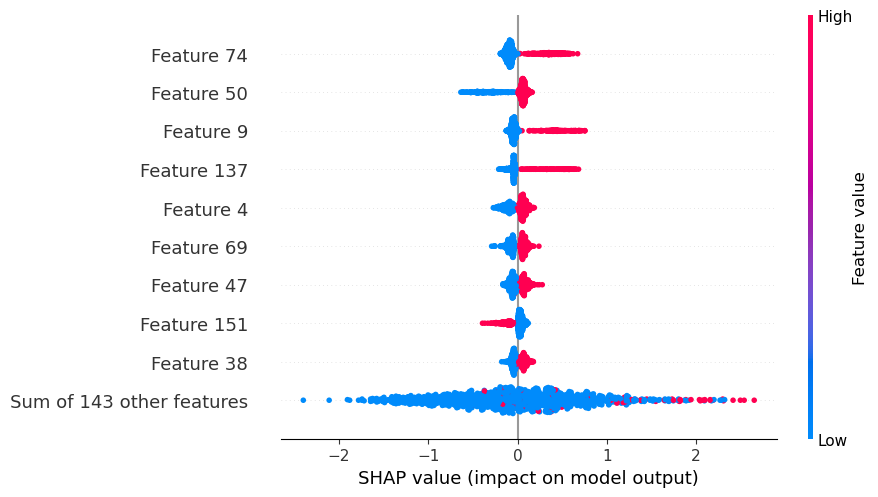

In [336]:
shap.plots.beeswarm(shap_values)

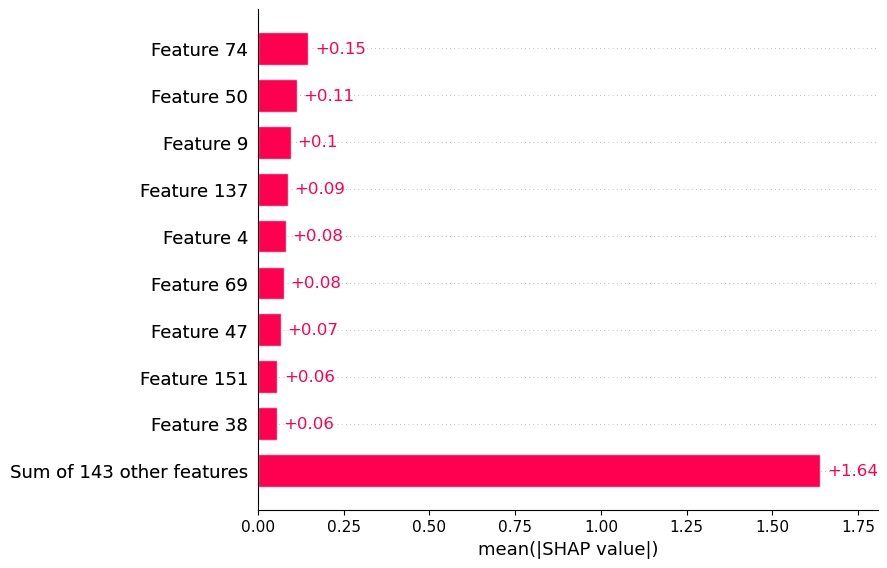

In [337]:
shap.plots.bar(shap_values)